# <center>Deep Learning and Optimization - Advanced Task</center>

## Import Libraries

In [1]:
#import all the required packages and dependecies
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image

env = gym.make('MountainCar-v0').unwrapped

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

In [2]:
#import and check the version of tensorflow
import tensorflow as tf
from collections import deque
print("Gym:", gym.__version__)
print("Tensorflow:", tf.__version__)

Gym: 0.15.4
Tensorflow: 1.15.0


## Print the observation and action space for the environment

In [3]:
#check the observation space - input and action space - output
print("Observation space:", env.observation_space)
print("Action space:", env.action_space)

Observation space: Box(2,)
Action space: Discrete(3)


## Deep Q Network Agent (without Experience Replay)

In [4]:
#define the Q network
class QNetwork():
    def __init__(self, state_dim, action_size):
        self.state_in = tf.placeholder(tf.float32, shape=[None, *state_dim]) #assign the state dimensions
        self.action_in = tf.placeholder(tf.int32, shape=[None]) #assign the action space
        self.q_target_in = tf.placeholder(tf.float32, shape=[None]) #assign the q target input
        action_one_hot = tf.one_hot(self.action_in, depth=action_size) #one hot encode the 3 actions
        
        self.hidden1 = tf.layers.dense(self.state_in, 100, activation=tf.nn.relu) #hidden layer with 100 neurons
        self.q_state = tf.layers.dense(self.hidden1, action_size, activation=None) #output layer with actions as output
        self.q_state_action = tf.reduce_sum(tf.multiply(self.q_state, action_one_hot), axis=1) #get the Q value from state action pair
      
        self.loss = tf.reduce_mean(tf.square(self.q_state_action - self.q_target_in)) #MSE loss is calculated
        self.optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(self.loss) #Adam optimizer with a learning rate of 0.001 used to minimize the loss
        
    def update_model(self, session, state, action, q_target): #update the model
        feed = {self.state_in: state, self.action_in: action, self.q_target_in: q_target} #assign inputs
        session.run(self.optimizer, feed_dict=feed) #run the session
        
    def get_q_state(self, session, state): #get the next state
        q_state = session.run(self.q_state, feed_dict={self.state_in: state})
        return q_state

In [5]:
class DQNAgent(): #create the Deep Q Network Agent
    def __init__(self, env):
        self.state_dim = env.observation_space.shape #input state with the observation space - 2 states
        self.action_size = env.action_space.n #input action space
        self.q_network = QNetwork(self.state_dim, self.action_size) #initialize the Q network with the above inputs
        self.gamma = 0.97 #set the discount rate
        self.eps = 1.0 #set the epsilon value for the e-greedy policy
        
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())
        
    def get_action(self, state): #get the ideal action
        q_state = self.q_network.get_q_state(self.sess, [state])
        action_greedy = np.argmax(q_state) #Exploitation to use the largest Q value
        action_random = np.random.randint(self.action_size) #Exploration by taking a random action
        action = action_random if random.random() < self.eps else action_greedy #decide exploration or exploitation
        return action
    
    def train(self, state, action, next_state, reward, done): #train the model
        q_next_state = self.q_network.get_q_state(self.sess, [next_state]) #get the next state
        q_next_state = (1-done) * q_next_state 
        q_target = reward + self.gamma * np.max(q_next_state) #define the reward using Bellman equation
        self.q_network.update_model(self.sess, [state], [action], [q_target]) #update the model weights
        
        if done: self.eps = max(0.1, 0.99*self.eps) #set the epsilon minimum to 0.1 and decay rate to 0.99
    
    def __del__(self):
        self.sess.close()

In [6]:
agent = DQNAgent(env) #assign the agent
num_episodes = 400 #define the number of episodes
WoER_plot_episodes = [] #create a list to store the episodes
WoER_plot_total_rewards = [] #create a list to store the total rewards from each episode
WoER_plot_rewards =[] #create a list to store the rewards from each episode

for ep in range(num_episodes): #define a for loop to run the episodes
    state = env.reset() #reset the environment at the start of every episode
    total_reward = 0 #initialise the total reward
    done = False
    while not done:
        action = agent.get_action(state) 
        next_state, reward, done, info = env.step(action) #get the next state, reward and if the episode is completed
        agent.train(state, action, next_state, reward, done) #train the agent
        env.render() #render the environment
        total_reward += reward #cumulative reward in each episode
        state = next_state #set the next state
    
    print("Episode: {}, total_reward: {:.2f}".format(ep, total_reward)) #print the values to check
    WoER_plot_episodes.append(ep) #append the episodes to the list
    WoER_plot_total_rewards.append(total_reward) #append the total rewards from the episode to the list
    WoER_plot_rewards.append(reward) #append the rewards from the episode to the list

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Episode: 0, total_reward: -27721.00
Episode: 1, total_reward: -5605.00
Episode: 2, total_reward: -14730.00
Episode: 3, total_reward: -6693.00
Episode: 4, total_reward: -42082.00
Episode: 5, total_reward: -39297.00
Episode: 6, total_reward: -10558.00
Episode: 7, total_reward: -17206.00
Episode: 8, total_reward: -1756.00
Episode: 9, total_reward: -15030.00
Episode: 10, total_reward: -17519.00
Episode: 11, total_reward: -14127.00
Episode: 12, total_reward: -24463.00
Episode: 13, total_reward: -62593.00
Episode: 14, total_reward: -2549.00
Episode: 15, total_reward: -10960.00
Episode: 16, total_reward: -7300.00
Episode: 17, total_reward: -28172.00
Episode: 18, total_reward: -1677.00
Episode: 19, total_reward: -25090.00
Episode: 20, total_reward: -2075.00
Episode: 21, total_reward: -32926.00
Episode: 22, total_reward: -44360.00
Episode: 23, total_reward: -658.00
E

Text(0.5, 1.0, 'Episodes vs Total Reward')

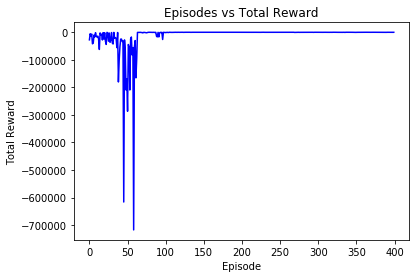

In [37]:
#plot the episodes vs total rewards obtained in this run
plt.plot(WoER_plot_episodes, WoER_plot_total_rewards, color='blue')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Episodes vs Total Reward')

In [10]:
# Define the Running Mean (Moving average)
def running_mean(x, N):
    """Evaluate the moving average of window N of a vector"""
    cum_sum = np.cumsum(np.insert(x, 0, 0)) 
    return (cum_sum[N:] - cum_sum[:-N]) / float(N)

In [40]:
#Calcuate the running mean for the rewards
WoER_DQN_totalrewards_runmean = running_mean(WoER_plot_total_rewards, 100)

In [41]:
WoER_DQN_totalrewards_runmean

array([-42495.53, -42231.26, -42183.4 , -42041.03, -41984.17, -41572.8 ,
       -41182.25, -41079.14, -40913.24, -40902.83, -40759.02, -40588.7 ,
       -40451.68, -40211.19, -39587.91, -39566.9 , -39462.22, -39391.76,
       -39115.07, -39102.4 , -38854.82, -38838.02, -38513.9 , -38072.6 ,
       -38070.75, -38052.54, -37729.23, -37702.92, -37340.6 , -37064.55,
       -37053.61, -36663.88, -36240.66, -36236.  , -36020.87, -35824.6 ,
       -35606.06, -35048.53, -35040.48, -33237.27, -32211.62, -31688.99,
       -31440.51, -31193.75, -30856.47, -30541.18, -24382.07, -24104.52,
       -23424.89, -21329.17, -19639.99, -16774.78, -16331.19, -15793.61,
       -13698.2 , -13455.02, -13283.02, -12459.05, -11903.04,  -4731.62,
        -4205.09,  -3905.01,  -2250.52,  -1287.45,  -1283.6 ,  -1278.27,
        -1275.72,  -1271.35,  -1270.4 ,  -1259.93,  -1252.71,  -1229.84,
        -1225.96,  -1221.76,  -1214.4 ,  -1198.85,  -1179.8 ,  -1169.57,
        -1167.77,  -1167.37,  -1167.83,  -1165.88, 

Text(0.5, 1.0, 'Running mean of reward by Episode')

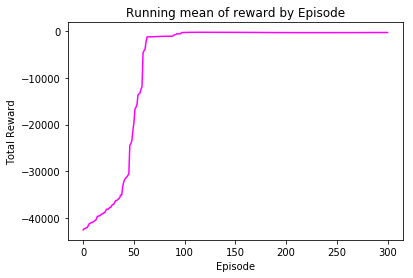

In [42]:
#Plot the running mean of the reward by episode
plt.plot(WoER_DQN_totalrewards_runmean,color='magenta')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Running mean of reward by Episode')

## Introducing Experience Replay

#### we use the same Q Network so that is not redefined

In [61]:
class ReplayBuffer(): #define the experience replay or replay buffer class
    def __init__(self, maxlen):
        self.buffer = deque(maxlen=maxlen) #initialise the maximum length of stored replay
        
    def add(self, experience):
        self.buffer.append(experience) #append the experience
        
    def sample(self, batch_size): #randomly sample a batch - define the batch size
        sample_size = min(len(self.buffer), batch_size)
        samples = random.choices(self.buffer, k=sample_size)
        return map(list, zip(*samples))

In [31]:
class DQNAgent1(): #create the Deep Q Network Agent to include replay buffer
    def __init__(self, env):
        self.state_dim = env.observation_space.shape #input state with the observation space - 2 states
        self.action_size = env.action_space.n #input action space
        self.q_network = QNetwork(self.state_dim, self.action_size) #initialize the Q network with the above inputs
        self.replay_buffer = ReplayBuffer(maxlen=10000) #set the length of replay storage or memory for experience replay
        self.gamma = 0.97 #set the discount rate
        self.eps = 1.0 #set the epsilon value for the e-greedy policy
        
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())
        
    def get_action(self, state): #get the ideal action
        q_state = self.q_network.get_q_state(self.sess, [state])
        action_greedy = np.argmax(q_state) #Exploitation to use the largest Q value
        action_random = np.random.randint(self.action_size) #Exploration by taking a random action
        action = action_random if random.random() < self.eps else action_greedy #decide exploration or exploitation
        return action
    
    def train(self, state, action, next_state, reward, done): #train the model
        self.replay_buffer.add((state, action, next_state, reward, done)) #use the experience replay
        states, actions, next_states, rewards, dones = self.replay_buffer.sample(50) #randomly sample 50 samples from memory
        q_next_states = self.q_network.get_q_state(self.sess, next_states) #get the next state
        q_next_states[dones] = np.zeros([self.action_size]) 
        q_targets = rewards + self.gamma * np.max(q_next_states, axis=1) #define the reward using Bellman equation
        self.q_network.update_model(self.sess, states, actions, q_targets) #update the model weights
        
        if done: self.eps = max(0.1, 0.99*self.eps) #set the epsilon minimum to 0.1 and decay rate to 0.99
    
    def __del__(self):
        self.sess.close()

In [32]:
agent = DQNAgent1(env) #assign the agent
num_episodes = 400 #define the number of episodes
to_plot_episodes = [] #create a list to store the episodes
to_plot_total_rewards = [] #create a list to store the total rewards from each episode
to_plot_rewards = [] #create a list to store the rewards from each episode

for ep in range(num_episodes): #define a for loop to run the episodes
    state = env.reset() #reset the environment at the start of every episode
    total_reward = 0 #initialise the total reward
    done = False
    while not done:
        action = agent.get_action(state) 
        next_state, reward, done, info = env.step(action) #get the next state, reward and if the episode is completed
        agent.train(state, action, next_state, reward, done) #train the agent
        env.render() #render the environment
        total_reward += reward #cumulative reward in each episode
        state = next_state #set the next state
    
    print("Episode: {}, total_reward: {:.2f}".format(ep, total_reward)) #print the values to check
    to_plot_episodes.append(ep) #append the episodes to the list
    to_plot_total_rewards.append(total_reward) #append the total rewards from the episode to the list
    to_plot_rewards.append(reward) #append the rewards from the episode to the list

Episode: 0, total_reward: -166832.00
Episode: 1, total_reward: -42524.00
Episode: 2, total_reward: -22217.00
Episode: 3, total_reward: -4874.00
Episode: 4, total_reward: -3907.00
Episode: 5, total_reward: -7116.00
Episode: 6, total_reward: -5578.00
Episode: 7, total_reward: -16110.00
Episode: 8, total_reward: -8751.00
Episode: 9, total_reward: -9916.00
Episode: 10, total_reward: -2317.00
Episode: 11, total_reward: -3193.00
Episode: 12, total_reward: -2090.00
Episode: 13, total_reward: -3320.00
Episode: 14, total_reward: -2801.00
Episode: 15, total_reward: -1443.00
Episode: 16, total_reward: -1220.00
Episode: 17, total_reward: -1557.00
Episode: 18, total_reward: -1908.00
Episode: 19, total_reward: -1156.00
Episode: 20, total_reward: -3141.00
Episode: 21, total_reward: -1919.00
Episode: 22, total_reward: -876.00
Episode: 23, total_reward: -957.00
Episode: 24, total_reward: -907.00
Episode: 25, total_reward: -652.00
Episode: 26, total_reward: -1131.00
Episode: 27, total_reward: -633.00
Ep

Text(0.5, 1.0, 'Episodes vs Total Reward')

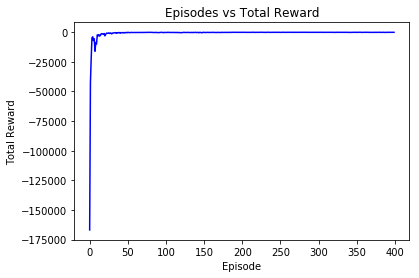

In [36]:
#plot the episodes vs total rewards obtained in this run
plt.plot(to_plot_episodes, to_plot_total_rewards, color='blue')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Episodes vs Total Reward')

In [38]:
#Calcuate the running mean for the rewards
DQN_totalrewards_runmean = running_mean(to_plot_total_rewards, 100)

Text(0.5, 1.0, 'Running mean of Total reward by Episode')

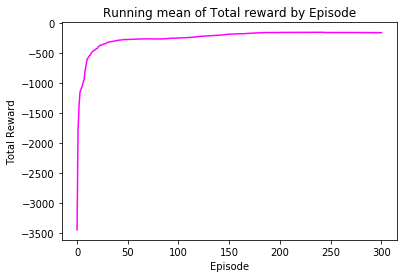

In [39]:
#Plot the running mean of the reward by episode
plt.plot(DQN_totalrewards_runmean,color='magenta')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Running mean of Total reward by Episode')

## Double Deep Q Network Agent (with Experience Replay)

In [64]:
#define the Q network for the DDQN
class QNetwork():
    def __init__(self, state_dim, action_size, tau=0.01):
        tf.reset_default_graph()
        self.state_in = tf.placeholder(tf.float32, shape=[None, *state_dim]) #assign the state dimensions
        self.action_in = tf.placeholder(tf.int32, shape=[None]) #assign the action space
        self.q_target_in = tf.placeholder(tf.float32, shape=[None]) #assign the q target input
        action_one_hot = tf.one_hot(self.action_in, depth=action_size) #one hot encode the 3 actions
        
        self.q_state_local = self.build_model(action_size, "local") #define the locak network
        self.q_state_target = self.build_model(action_size, "target") #define the target network which gets the targer Q values
        
        self.q_state_action = tf.reduce_sum(tf.multiply(self.q_state_local, action_one_hot), axis=1) #get the Q value from state action pair
        self.loss = tf.reduce_mean(tf.square(self.q_state_action - self.q_target_in)) #MSE loss is calculated
        self.optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(self.loss) #Adam optimizer with a learning rate of 0.001 used to minimize the loss 
        
        self.local_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="local") #to access the local network's weights and bias variables
        self.target_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="target") #to access the target network's weights and bias variables
        self.updater = tf.group([tf.assign(t, t + tau*(l-t)) for t,l in zip(self.target_vars, self.local_vars)]) #calculate the values using the update rate tau
    
    def build_model(self, action_size, scope):
        with tf.variable_scope(scope):
            hidden1 = tf.layers.dense(self.state_in, 100, activation=tf.nn.relu) #hidden layer with 100 neurons
            q_state = tf.layers.dense(hidden1, action_size, activation=None) #output layer with action size as output
            return q_state
        
    def update_model(self, session, state, action, q_target): #update the model
        feed = {self.state_in: state, self.action_in: action, self.q_target_in: q_target} #assign inputs
        session.run(self.optimizer, feed_dict=feed) #run the session
        
    def get_q_state(self, session, state, use_target = False): #get the next state and initialise which q value to take
        q_state_output = self.q_state_target if use_target else self.q_state_local #condition for choice of q state from either local or target network
        q_state = session.run(q_state_output, feed_dict={self.state_in: state})
        return q_state

#### We use the same replay buffer class as defined earlier

In [65]:
class DoubleDQNAgent(): #create the Double Deep Q Network Agent class
    def __init__(self, env):
        self.state_dim = env.observation_space.shape #input state with the observation space - 2 states
        self.action_size = env.action_space.n #input action space
        self.q_network = QNetwork(self.state_dim, self.action_size) #initialize the Q network with the above inputs
        self.replay_buffer = ReplayBuffer(maxlen=10000) #set the length of replay storage
        self.gamma = 0.97 #set the discount rate
        self.eps = 1.0 #set the epsilon value for the e-greedy policy
        
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())
        
    def get_action(self, state): #get the ideal action
        q_state = self.q_network.get_q_state(self.sess, [state])
        action_greedy = np.argmax(q_state) #Exploitation to use the largest Q value
        action_random = np.random.randint(self.action_size) #Exploration by taking a random action
        action = action_random if random.random() < self.eps else action_greedy #decide exploration or exploitation
        return action
    
    def train(self, state, action, next_state, reward, done, use_DDQN = True): #train the model with a choice of DQN and DDQN
        self.replay_buffer.add((state, action, next_state, reward, done)) #use the replay buffer
        states, actions, next_states, rewards, dones = self.replay_buffer.sample(50)
        
        next_actions = np.argmax(self.q_network.get_q_state(self.sess, next_states, use_target=False), axis=1) #select the action wtih maximum Q value
        q_next_states = self.q_network.get_q_state(self.sess, next_states) #get the next state
        q_next_states[dones] = np.zeros([self.action_size])
        q_next_states_next_actions = q_next_states[np.arange(next_actions.shape[0]), next_actions]
        q_targets = rewards + self.gamma * q_next_states_next_actions #define the reward using Bellman equation
        self.q_network.update_model(self.sess, states, actions, q_targets) #update the model weights
        
        if done: self.eps = max(0.1, 0.99*self.eps) #set the epsilon minimum to 0.1 and decay rate to 0.99
    
    def __del__(self):
        self.sess.close()

In [75]:
agent = DoubleDQNAgent(env) #assign the agent
num_episodes = 400 #define the number of episodes
DDQN_plot_episodes = [] #create a list to store the episodes
DDQN_plot_total_rewards = [] #create a list to store the total rewards from each episode
DDQN_plot_rewards = [] #create a list to store the rewards from each episode

for ep in range(num_episodes): #define a for loop to run the episodes
    state = env.reset() #reset the environment at the start of every episode
    total_reward = 0 #initialise the total reward
    done = False
    while not done:
        action = agent.get_action(state) 
        next_state, reward, done, info = env.step(action) #get the next state, reward and if the episode is completed
        agent.train(state, action, next_state, reward, done) #train the agent
        env.render() #render the environment
        total_reward += reward #cumulative reward in each episode
        state = next_state #set the next state
    
    print("Episode: {}, total_reward: {:.2f}".format(ep, total_reward)) #print the values to check
    DDQN_plot_episodes.append(ep) #append the episodes to the list
    DDQN_plot_total_rewards.append(total_reward) #append the total rewards from the episode to the list
    DDQN_plot_rewards.append(reward) #append the rewards from the episode to the list

Episode: 0, total_reward: -34007.00
Episode: 1, total_reward: -6747.00
Episode: 2, total_reward: -13227.00
Episode: 3, total_reward: -25697.00
Episode: 4, total_reward: -1705.00
Episode: 5, total_reward: -9312.00
Episode: 6, total_reward: -2339.00
Episode: 7, total_reward: -5924.00
Episode: 8, total_reward: -6216.00
Episode: 9, total_reward: -3122.00
Episode: 10, total_reward: -1184.00
Episode: 11, total_reward: -4144.00
Episode: 12, total_reward: -1382.00
Episode: 13, total_reward: -2516.00
Episode: 14, total_reward: -1521.00
Episode: 15, total_reward: -999.00
Episode: 16, total_reward: -1551.00
Episode: 17, total_reward: -2990.00
Episode: 18, total_reward: -1149.00
Episode: 19, total_reward: -718.00
Episode: 20, total_reward: -1020.00
Episode: 21, total_reward: -1219.00
Episode: 22, total_reward: -1069.00
Episode: 23, total_reward: -1238.00
Episode: 24, total_reward: -493.00
Episode: 25, total_reward: -1021.00
Episode: 26, total_reward: -1031.00
Episode: 27, total_reward: -490.00
Epi

Text(0.5, 1.0, 'Episodes vs Total Reward')

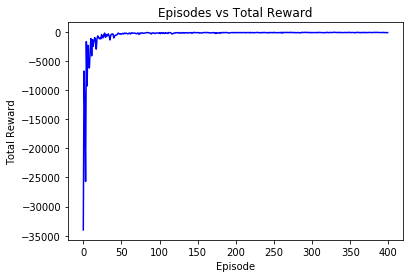

In [76]:
#plot the episodes vs total rewards obtained in this run
plt.plot(DDQN_plot_episodes, DDQN_plot_total_rewards, color='blue')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Episodes vs Total Reward')

In [77]:
#Calcuate the running mean for the rewards
DDQN_totalrewards_runmean = running_mean(DDQN_plot_total_rewards, 100)

Text(0.5, 1.0, 'Running mean of Total reward by Episode')

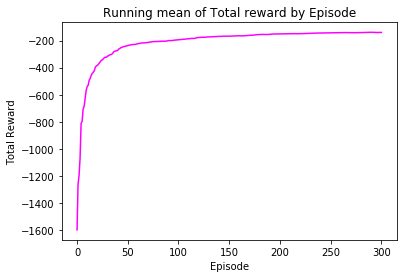

In [78]:
#Plot the running mean of the reward by episode
plt.plot(DDQN_totalrewards_runmean,color='magenta')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Running mean of Total reward by Episode')

## Comparing DDQN and DQN in alternate runs

In [67]:
num_runs = 10 #number of runs of either or agent
run_rewards = [] #store the run rewards
epis = []
DDQNtotal_rewards = []

for n in range(num_runs):
    print("Run {}".format(n))
    ep_rewards = [] #store the total rewards
    agent = None
    agent = DoubleDQNAgent(env)
    num_episodes = 400 #number of episodes in each run

    for ep in range(num_episodes):
        state = env.reset() #reset the environment before every episode
        total_reward = 0 #initialise the total reward
        done = False #condition
        while not done:
            action = agent.get_action(state) #choose the action
            next_state, reward, done, info = env.step(action) #get the outputs from the environment based on action
            agent.train(state, action, next_state, reward, done, use_DDQN=(n%2==0)) #select if agent will train on DQN or DDQN
            #env.render()
            total_reward += reward #calculate the total reward
            state = next_state #set state as next state

        ep_rewards.append(total_reward) #append the total reward to above initialised list
        print("Episode: {}, total_reward: {:.2f}".format(ep, total_reward)) #print and verify
        epis.append(ep)
        DDQNtotal_rewards.append(total_reward)
    run_rewards.append(ep_rewards) #append rewards to above initialised list

Run 0
Episode: 0, total_reward: -10357.00
Episode: 1, total_reward: -55010.00
Episode: 2, total_reward: -3059.00
Episode: 3, total_reward: -11038.00
Episode: 4, total_reward: -4204.00
Episode: 5, total_reward: -2296.00
Episode: 6, total_reward: -5092.00
Episode: 7, total_reward: -7422.00
Episode: 8, total_reward: -1431.00
Episode: 9, total_reward: -2669.00
Episode: 10, total_reward: -4215.00
Episode: 11, total_reward: -1822.00
Episode: 12, total_reward: -905.00
Episode: 13, total_reward: -726.00
Episode: 14, total_reward: -1758.00
Episode: 15, total_reward: -1354.00
Episode: 16, total_reward: -822.00
Episode: 17, total_reward: -931.00
Episode: 18, total_reward: -696.00
Episode: 19, total_reward: -1220.00
Episode: 20, total_reward: -985.00
Episode: 21, total_reward: -985.00
Episode: 22, total_reward: -619.00
Episode: 23, total_reward: -580.00
Episode: 24, total_reward: -506.00
Episode: 25, total_reward: -474.00
Episode: 26, total_reward: -504.00
Episode: 27, total_reward: -340.00
Episod

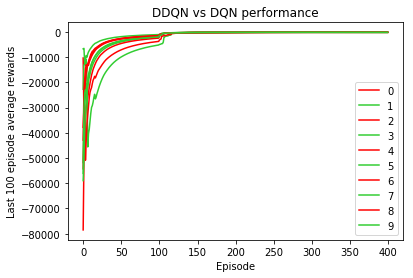

In [84]:
%matplotlib inline

#define the plot for comparing DDQN vs DQN performance where every even run is trained using a DDQN Agent and odd run is trained using DQN Agent

for n, ep_rewards in enumerate(run_rewards):
    x = range(len(ep_rewards))
    cumsum = np.cumsum(ep_rewards)
    avgs = [cumsum[ep]/(ep+1) if ep<100 else (cumsum[ep]-cumsum[ep-100])/100 for ep in x]
    col = "r" if (n%2==0) else "limegreen"
    plt.plot(x, avgs, color=col, label=n)
    
plt.title("DDQN vs DQN performance")
plt.xlabel("Episode")
plt.ylabel("Last 100 episode average rewards")
plt.legend()